## Échanger quantiquement une clé

### Alice prépare, envoie

1. |1⟩ + H
1. |0⟩ 
1. |1⟩ + H
1. |0⟩ + H
1. |1⟩
1. |1⟩ + H
1. |0⟩
1. |1⟩ + H

### Bob reçoit, traite, demande

#### Réception/traitement

<table>
<tr><th></th><th>Reçu</th><th>Aléatoire</th><th>Mesure</th></tr>
<tr><td>1</td><td>|1⟩ + H</td><td></td><td>0/1</td></tr>
<tr><td>2</td><td>|0⟩ </td><td>H</td><td>0/1</td></tr>
<tr><td>3</td><td>|1⟩ + H</td><td></td><td>0/1</td></tr>
<tr><td>4</td><td>|0⟩ + H</td><td>H</td><td>0</td></tr>
<tr><td>5</td><td>|1⟩</td><td></td><td>1</td></tr>
<tr><td>6</td><td>|1⟩ + H</td><td></td><td>0/1</td></tr>
<tr><td>7</td><td>|0⟩</td><td>H </td><td>0/1</td></tr>
<tr><td>8</td><td>|1⟩ + H</td><td>H</td><td>1</td></tr>
</table>

#### Envoi "J'ai fait H sur... Que garder ?"

J'ai fait H sur **2, 4, 7, 8** Que garder ? 

### Alice répond

<table>
<tr><th></th><th>A</th><th>B</th><th></th></tr>
<tr><td>1</td><td>H</td><td> </td><td></td></tr>
<tr><td>2</td><td> </td><td>H</td><td></td></tr>
<tr><td>3</td><td>H</td><td> </td><td></td></tr>
<tr><td>4</td><td>H</td><td>H</td><td>ok</td></tr>
<tr><td>5</td><td> </td><td> </td><td>ok</td></tr>
<tr><td>6</td><td>H</td><td> </td><td></td></tr>
<tr><td>7</td><td> </td><td>H</td><td></td></tr>
<tr><td>8</td><td>H</td><td>H</td><td>ok</td></tr>
</table>
Message à Bob : 4, 5, 8

Clé est : 0,  1, 1

### Bob déduit la clé

Clé est : 0, 1, 1

## Simuler un QKD

### Objets

In [2]:
import random
import math
from numpy import ndarray
from qiskit import transpile
from qiskit_aer import Aer
from qiskit.circuit import QuantumCircuit


def masque_qubits(mask: int, size: int) -> list[int]:
  return [i for i in range(size) if (1 << i) & mask]

In [3]:
class Cle:
  def __init__(self, masque_commun: int, valeurs: int):
    self.masque_commun = masque_commun
    self.cle = 0
    self.taille = 0
    while masque_commun > 0 and valeurs > 0:
      if masque_commun & 1:
        self.cle |= (1 << self.taille) if valeurs & 1 else 0
        self.taille += 1
      masque_commun >>= 1
      valeurs >>= 1

  def get_masque_commun(self) -> int:
    return self.masque_commun

  def get_cle(self) -> int:
    return self.cle

  def get_taille(self) -> int:
    return self.taille

In [4]:
class Alice:
  def __init__(self, taille_cle: int):
    self.taille_cle = taille_cle
    self.nb_qubits = taille_cle * 3
    max = 1 << self.nb_qubits
    self.masque_b = random.randrange(max)
    self.masque_h = random.randrange(max)
    self.circuit = QuantumCircuit(self.nb_qubits)
    self.circuit.x(masque_qubits(self.masque_b, max))
    self.circuit.h(masque_qubits(self.masque_h, max))

  def get_qubits(self) -> ndarray:
    simulateur = Aer.get_backend('statevector_simulator')
    resultat = simulateur.run(
        transpile(self.circuit, simulateur), shots=256).result()
    return resultat.get_statevector(self.circuit)

  def get_cle(self, masque_commun: int) -> Cle:
    toutA1 = (1 << self.nb_qubits)-1
    return Cle(masque_commun ^ self.masque_h ^ toutA1, self.masque_b)

  def dessiner_circuit(self):
    return self.circuit.draw()

In [5]:
class Bob:
  def __init__(self, etats: ndarray):
    self.nb_qubits = int(math.log2(len(etats)))
    self.taille_cle = self.nb_qubits//3
    max = 1 << self.nb_qubits
    self.masque_h = random.randrange(max)
    self.circuit = QuantumCircuit(self.nb_qubits)
    self.circuit.prepare_state(etats)
    self.circuit.h(masque_qubits(self.masque_h, max))
    self.circuit.measure_all()

  def get_masque_h(self) -> int:
    return self.masque_h

  def dessiner_circuit(self):
    return self.circuit.draw()

  def get_cle(self, masque_correspondance: int) -> Cle:
    simulateur = Aer.get_backend('qasm_simulator')
    compile = transpile(self.circuit, simulateur)
    job = simulateur.run(compile, shots=100)
    result = job.result().get_counts(compile).int_outcomes()
    return Cle(masque_correspondance, max(result, key=result.get))


### Alice prépare, envoie

In [6]:
alice = Alice(3)
canal_quantique = alice.get_qubits()
alice.dessiner_circuit()

┌───┐     
q_0: ┤ X ├─────
     └───┘     
q_1: ──────────
     ┌───┐     
q_2: ┤ H ├─────
     ├───┤     
q_3: ┤ X ├─────
     ├───┤     
q_4: ┤ X ├─────
     ├───┤┌───┐
q_5: ┤ X ├┤ H ├
     ├───┤├───┤
q_6: ┤ X ├┤ H ├
     └───┘└───┘
q_7: ──────────
     ┌───┐     
q_8: ┤ X ├─────
     └───┘

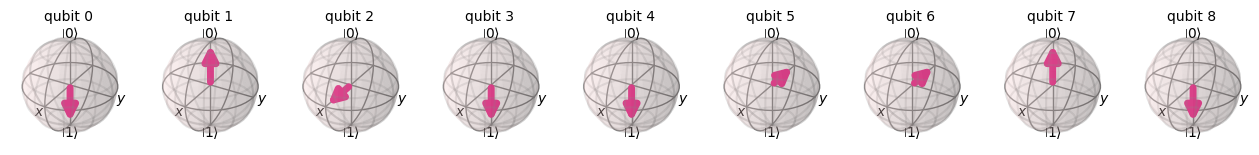

In [7]:
from qiskit.visualization import plot_bloch_multivector

plot_bloch_multivector(canal_quantique)

### Bob reçoit, traite, demande 

In [8]:
bob = Bob(canal_quantique)
bob.dessiner_circuit()

/tmp/ipykernel_2733/1671132818.py:3: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  self.nb_qubits = int(math.log2(len(etats)))


»
   q_0: »
        »
   q_1: »
        »
   q_2: »
        »
   q_3: »
        »
   q_4: »
        »
   q_5: »
        »
   q_6: »
        »
   q_7: »
        »
   q_8: »
        »
meas: 9/»
        »
«        ┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«   q_0: ┤0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        ├»
«        │                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         │»
«   q_1: ┤1                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [9]:
canal_public_ba = bob.get_masque_h()
"{0:b}".format(canal_public_ba)

'100110111'

### Alice répond

In [10]:
cle_alice = alice.get_cle(canal_public_ba)
canal_public_ab = cle_alice.get_masque_commun()
vars(cle_alice)

{'masque_commun': 172, 'cle': 6, 'taille': 4}

### Bob déduit la clé

In [11]:
cle_bob = bob.get_cle(canal_public_ab)
vars(cle_bob)

{'masque_commun': 172, 'cle': 6, 'taille': 3}